In [1]:
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import pandas as pd
import numpy as np

from pathlib import Path

In [2]:
# Folder path
path = Path("../data/selected")

# Load data (already split)
X_train = pd.read_csv(path / "X_train_selected.csv")
y_train = pd.read_csv(path / "y_train.csv")

print(X_train.shape)

(1934, 14)


In [3]:
RANDOM_STATE = 42
CV_SPLITS = 5
SEARCH_ITER = 10
SCORING = "roc_auc_ovr"  # chosen because we will tune threshold later; could be recall_macro or f1_macro

# Pipeline with forward feature selection + MLP
pipe = Pipeline(
    steps=[
        (
            "feature_selection",
            SequentialFeatureSelector(
                estimator=MLPClassifier(
                    hidden_layer_sizes=(32,),
                    max_iter=100,
                    random_state=RANDOM_STATE,
                ),
                direction="forward",
                n_features_to_select=5,
                scoring=SCORING,
                cv=CV_SPLITS,
                n_jobs=-1,
            ),
        ),
        (
            "mlp",
            MLPClassifier(
                max_iter=100,
                hidden_layer_sizes=(32,),
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)
# Outer CV for Bayes search
cv = StratifiedKFold(
    n_splits=CV_SPLITS,
    shuffle=True,
    random_state=RANDOM_STATE,
)

layer_configs = [
    (32,),
    (32, 16),
]

scalar_space = {
    "mlp__alpha": Real(1e-5, 1e-1, prior="log-uniform"),
    "mlp__learning_rate_init": Real(1e-4, 1e-1, prior="log-uniform"),
    "mlp__activation": Categorical(["relu"]),
}

best_score = -np.inf
best_params = None
best_layers = None
best_model = None

In [ ]:
import warnings

warnings.filterwarnings("ignore")

for layers in layer_configs:
    pipe.set_params(mlp__hidden_layer_sizes=layers)
    print(f"Fitting: {layers}")
    search = BayesSearchCV(
        estimator=pipe,
        search_spaces=scalar_space,
        n_iter=SEARCH_ITER,
        cv=cv,
        scoring=SCORING,
        n_jobs=-1,
        refit=True,
        random_state=RANDOM_STATE,
        verbose=0,
    )
    search.fit(X_train, y_train)

    print(f"Model fited with: ", layers, search.best_score_)

    if search.best_score_ > best_score:
        best_score = search.best_score_
        best_params = search.best_params_
        best_model = search.best_estimator_
        best_layers = layers

Fitting: (32,)
Model fited with:  (32,) 0.9472835551738944
Fitting: (32, 16)
Model fited with:  (32, 16) 0.9468738085015028
Best layers: (32,)


In [5]:
print("Best CV mean score:", best_score)
print("Best layers:", best_layers)

# Merge layers into params dict for convenience
best_params_with_layers = {
    **best_params,
    "mlp__hidden_layer_sizes": best_layers,
}
print("Best params (incl. layers):", best_params_with_layers)

Best CV mean score: 0.9472835551738944
Best layers: (32,)
Best params (incl. layers): {'mlp__activation': 'relu', 'mlp__alpha': 4.869521028037488e-05, 'mlp__learning_rate_init': 0.006225026900894044, 'mlp__hidden_layer_sizes': (32,)}


In [8]:
sfs = best_model.named_steps["feature_selection"]

selected_mask = sfs.get_support()
selected_features = X_train.columns[selected_mask]

print("Selected features:", list(selected_features))

Selected features: ['cat__BehavioralProblems_1', 'cat__MemoryComplaints_0', 'num__ADL', 'num__FunctionalAssessment', 'num__MMSE']


AUC: 0.9613754385964912


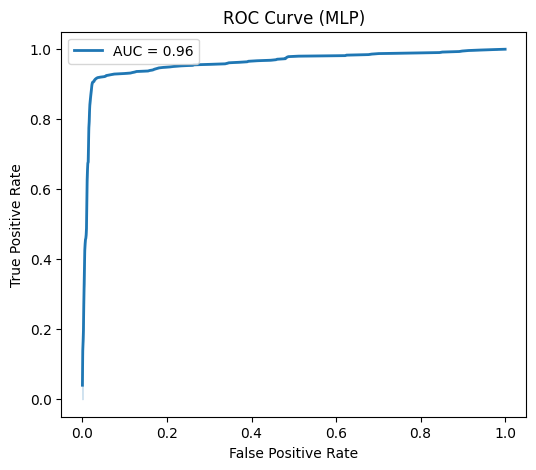

In [6]:
import sys

sys.path.append(".")
sys.path.append("..")

from helpers.roc_utils import plot_roc

auc = plot_roc(best_model, X_train, y_train, title="ROC Curve (MLP)")
print("AUC:", auc)

In [7]:
import pickle

model_path = Path("../data/models")
model_path.mkdir(parents=True, exist_ok=True)

with open(model_path / "MLP_best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)